Validation Accuracy: 0.6446666666666667
Classification Report on Validation Set:
              precision    recall  f1-score   support

    negative       0.65      0.67      0.66      1500
     neutral       0.58      0.58      0.58      1500
    positive       0.71      0.68      0.70      1500

    accuracy                           0.64      4500
   macro avg       0.65      0.64      0.64      4500
weighted avg       0.65      0.64      0.64      4500

Test Accuracy: 0.6397777777777778
Classification Report on Test Set:
              precision    recall  f1-score   support

    negative       0.62      0.68      0.65      1500
     neutral       0.57      0.56      0.56      1500
    positive       0.74      0.68      0.71      1500

    accuracy                           0.64      4500
   macro avg       0.64      0.64      0.64      4500
weighted avg       0.64      0.64      0.64      4500



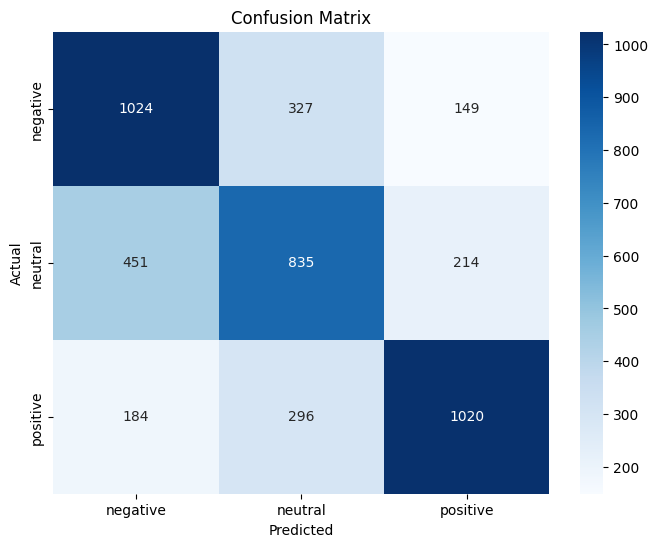

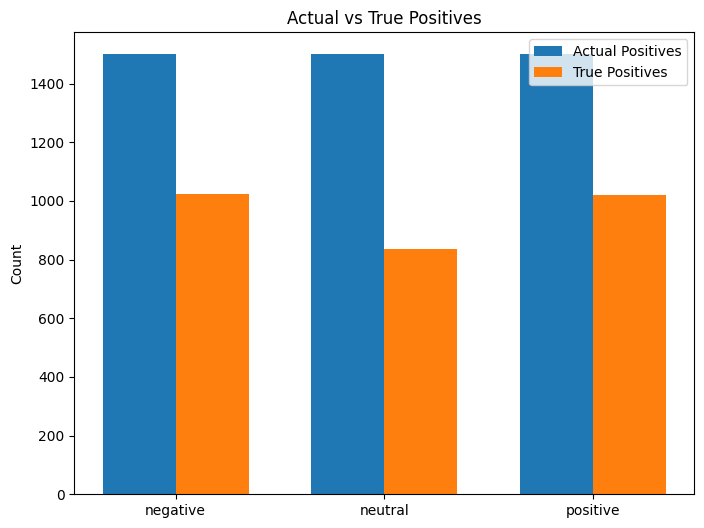

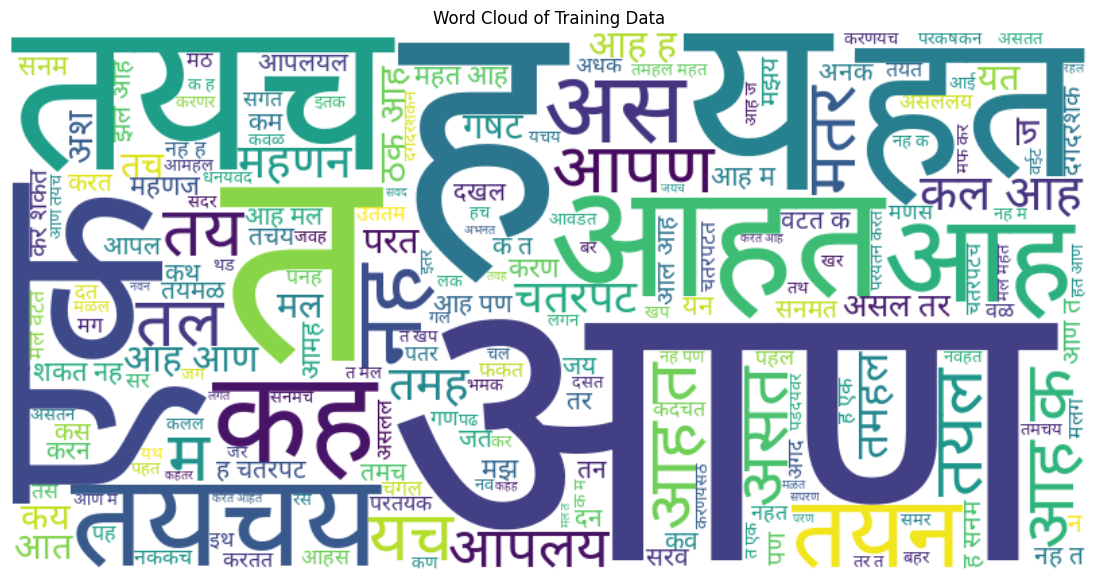

In [2]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# ---------- 1. Download the NotoSansDevanagari font ----------

font_url = "https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf"
font_path = "NotoSansDevanagari-Regular.ttf"

if not os.path.exists(font_path):
    print("Downloading Devanagari font...")
    r = requests.get(font_url)
    with open(font_path, "wb") as f:
        f.write(r.content)
    print("Font downloaded!")

# ---------- 2. Load datasets ----------

base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(base_dir, 'output', 'combined_dataset')

train_path = os.path.join(data_dir, 'train_strict.csv')
val_path = os.path.join(data_dir, 'val_strict.csv')
test_path = os.path.join(data_dir, 'test_strict.csv')

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# ---------- 3. Preprocessing ----------

for df in [train_df, val_df, test_df]:
    df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)

# ---------- 4. Feature extraction ----------

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])

# ---------- 5. Encode labels ----------

le = LabelEncoder()
y_train = le.fit_transform(train_df['label'])
y_val = le.transform(val_df['label'])
y_test = le.transform(test_df['label'])

# ---------- 6. Train the Naive Bayes classifier ----------

model = MultinomialNB()
model.fit(X_train, y_train)

# ---------- 7. Evaluate on validation set ----------

val_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Classification Report on Validation Set:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

# ---------- 8. Evaluate on test set ----------

test_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Classification Report on Test Set:")
print(classification_report(y_test, test_pred, target_names=le.classes_))

# ---------- 9. Confusion Matrix ----------

cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ---------- 10. Actual vs True Positive Plot ----------

actual_counts = np.bincount(y_test, minlength=len(le.classes_))
true_positives = np.zeros(len(le.classes_))

for i in range(len(y_test)):
    if y_test[i] == test_pred[i]:
        true_positives[y_test[i]] += 1

x = np.arange(len(le.classes_))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, actual_counts, width, label='Actual Positives')
plt.bar(x + width/2, true_positives, width, label='True Positives')
plt.xticks(x, le.classes_)
plt.ylabel('Count')
plt.title('Actual vs True Positives')
plt.legend()
plt.show()

# ---------- 11. Word Cloud using Devanagari font ----------

all_text = ' '.join(train_df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      font_path=font_path).generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Training Data')
plt.show()
